<img src="banner.png" align="left">

In [1]:
import pynq
import time
from pynq import PL
import xrfclk
import xrfdc
import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio
import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.daccomb as daccomb
import mkidgen3
import mkidgen3.util
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc
from mkidgen3.ifboard import IFBoard
import logging
from logging import getLogger
import json

In [2]:
ol = g3.configure('opfb_rfdc_loopback.bit', clocks=True, external_10mhz=True, ignore_version=True)
print(f"PL Bitfile: {PL.bitfile_name}\nPL Timestamp: {PL.timestamp}\n"
      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")

PL Bitfile: /home/xilinx/jupyter_notebooks/fccm22_demo/opfb_rfdc_loopback.bit
PL Timestamp: 2022/5/7 23:47:24 +961443
Overlay timestamp: 2022/5/7 23:47:24 +961443  Loaded: True


## Setup DAC REPLAY

In [3]:
# Optional: Inject Noise
snr = 10
a_noise = 10**((20*np.log10(1/np.sqrt(2)) - snr)/10)
in_noise = np.sqrt(a_noise)*(np.random.uniform(-1,1,size=2**19) + 1j*np.random.uniform(-1,1,size=2**19))

In [4]:
# Pick Tones to Send in (-2047 to 2048 MHz)
tones = np.array([300e6, 300.5e6])
amplitudes = np.ones_like(tones)/tones.shape[0]

In [5]:
dactable = generate_dac_comb(frequencies=tones, n_samples=2**19, sample_rate=4.096e9, amplitudes=amplitudes)

In [6]:
iq_quantized = ((dactable['iq'])*2048).round().clip(-2048,2047)*16 #quantize like ADC
dactable['iq']= iq_quantized
ol.dac_table_axim_0.stop()
ol.dac_table_axim_0.replay(dactable['iq'], fpgen=lambda x: x.astype(np.int16))

## DAC Replay "ADC Capture"

In [11]:
adc_cap_result=ol.capture.capture_adc(2**19)
adc_capture_data = adc_cap_result[:,0] + 1j*adc_cap_result[:,1]
adc_capture_data/=2**15
del adc_cap_result

In [12]:
adc_capture_data.shape

(524288,)

### Plots

In [13]:
N = 2**19
Fs = 4.096e9 # ADC Sample Rate [Hz]
Tc = N/Fs # total collection time (seconds)
time = np.linspace(0,Tc,N) # Time vector (seconds)

### Timeseries

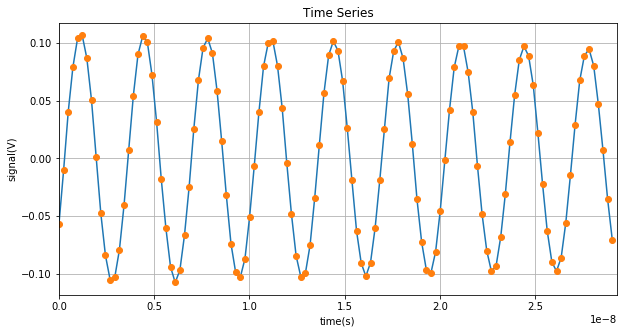

In [14]:
timeseries_plot_start=0
timeseries_plot_stop= 120#20*4096+16
timeseries_sl = slice(timeseries_plot_start,timeseries_plot_stop)

plt.figure(figsize=(10,5))
# plt.plot(time[sl],(ps_buf&0xffff)[sl].astype(np.int16), '-', label='real')
plt.plot(time[timeseries_sl],adc_capture_data.real[timeseries_sl])
plt.plot(time[timeseries_sl],adc_capture_data.real[timeseries_sl],"o")
plt.grid(True)
plt.xlabel("time(s)",position=(0.5,1))
plt.ylabel("signal(V)",position=(0,0.5))
ax = plt.gca()
ax.set_xlim(time[timeseries_plot_start],time[timeseries_plot_stop])
#plt.legend()
plt.title('Time Series')
plt.show()

In [27]:
importlib.reload(mkidgen3.plotting)

<module 'mkidgen3.plotting' from '/home/xilinx/src/mkidgen3/mkidgen3/plotting.py'>

In [16]:
import mkidgen3.plotting

AttributeError: 'NoneType' object has no attribute 'set_xlim'

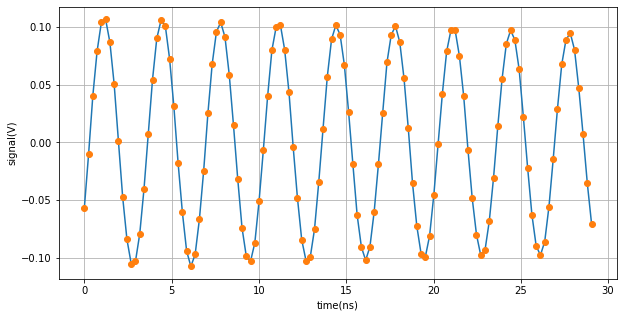

In [17]:
mkidgen3.plotting.plt_adc_timeseries(adc_capture_data,0,120)

### FFT

In [10]:
fft_start = 16
fft_stop = 20*4096+16
fft_sl = slice(fft_start, fft_stop)
fft_freqs = np.linspace(-2.048e9,2.048e9,fft_stop-fft_start)
y_fft = (np.abs(fftshift(fft(adc_capture_data[fft_sl]))))         # Calculate the FFT, and also shift so that f=0Hz is in the center.

In [11]:
def plot_fft(f, y, log=False, xlim=(-2.048e9,2.048e9), ylim=None):
    plt.plot(fft_freqs[::2],y_fft[::2] - max(y_fft)) # Plot every other
    plt.grid(True)
    ax = plt.gca()
    if log:
        plt.yscale("log")
    if ylim is not None:
        plt.ylim(*ylim)
    if xlim is not None:
        plt.xlim(*xlim)
    plt.xlabel("Frequency[Hz]", position=(0.5,0.5))
    plt.ylabel("power", position=(1,0.5))
    plt.title('FFT')

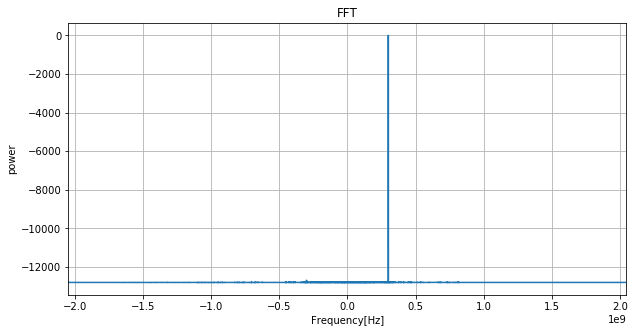

In [12]:
plt.figure(figsize=(10,5))
#plt.subplot(211)
plot_fft(fft_freqs[::2], y_fft[::2] - max(y_fft))
#plt.subplot(212)
#plot_fft(fft_freqs[::2], y_fft[::2] - max(y_fft), xlim=(75e6,125e6))
#plt.tight_layout()
#plt.xlim(-2.5e9,2.5e9)

(290000000.0, 310000000.0)

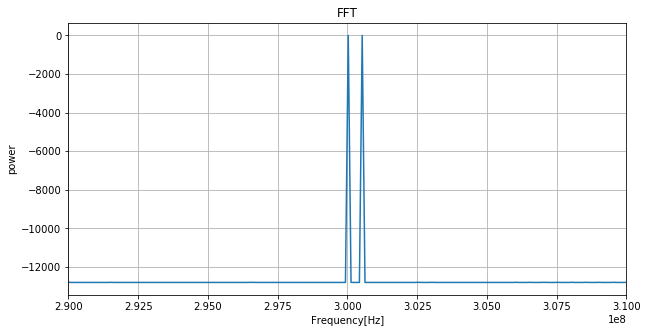

In [13]:
plt.figure(figsize=(10,5))
#plt.subplot(211)
plot_fft(fft_freqs[::2], y_fft[::2] - max(y_fft))
#plt.subplot(212)
#plot_fft(fft_freqs[::2], y_fft[::2] - max(y_fft), xlim=(75e6,125e6))
#plt.tight_layout()
plt.xlim(2.9e8,3.1e8)

## OPFB Capture

In [14]:
def capture_opfb(n=256):
    out=np.zeros((n,4096,2),dtype=np.int16)
    ol.photon_pipe.reschan.bin_to_res.bins = range(0, 2048)
    first_half_bins = ol.capture.capture_iq(n, 'all', tap_location='rawiq')
    out[:,:2048,:]=first_half_bins
    ol.photon_pipe.reschan.bin_to_res.bins = range(2048,4096)
    second_half_bins = ol.capture.capture_iq(n, 'all', tap_location='rawiq')
    out[:,2048:,:]=second_half_bins
    return out

In [15]:
opfb_raw_out = capture_opfb(1024)

In [16]:
#Convert to np.complex128
opfb_fp = opfb_raw_out[...,0] + 1j*(opfb_raw_out[...,1])

In [17]:
opfb_shifted = np.roll(opfb_fp,16,axis=1)

# Plot OPFB

In [18]:
def opfb_bin_spectrum(data, bins=None, shift = True, left_snip=1, db=True): 
    """
    Inputs:
    - bin: OPFB bin number (allowed values 0 - 4095)
    - data: Raw data out of OPFB. Should be in the form N x 4096 where N is the number of samples from a single bin.
    - shift: boolean. Either apply to every OPFB bin or don't (this should always be applied).
    - left_snip: Cuts out the left most sample in a bin. This is an annoying crutch to handle the 
        fact we place the N/2 bin on the far left.
        See https://www.gaussianwaves.com/2015/11/interpreting-fft-results-complex-dft-frequency-bins-and-fftshift/
        for explanation.
        
    Output:
    - Returns spectrum of a single FFT bin.
    """
    bins=np.asarray(bins).astype(int)
    if db:
        x = 20*np.log10(np.abs(np.fft.fft(data,axis=0)))
    if shift:
        x=np.fft.fftshift(x, axes=0)
    return np.flip(x[left_snip:,bins],axis=0)

In [19]:
def opfb_bin_freq(bins, resolution, Fs=4.096e9, M=4096, OS=2, left_snip=1):
    """
    Inputs:
    - bin: OPFB bin (0-4095). bin 0 contains -2048 to -2046 MHz, bin 4095 contains 2045 to 2047 MHz.
    - resolution: the number of samples from a single bin to take the FFT of. This dictates the frequency 
        resolution in a single OPFB bin.
    - Fs: ADC Sampling Rate.
    - M: OPFB FFT Size.
    - OS: Oversample ratio.
    - left_snip: Cuts out the left most sample in a bin. This is an annoying crutch to handle the 
        fact we place the N/2 bin on the far left.
        See https://www.gaussianwaves.com/2015/11/interpreting-fft-results-complex-dft-frequency-bins-and-fftshift/
        for explanation.
        
    Outputs:
    - Returns an array of frequency values in Hz for the given OPFB bin. """
    try:
        len(bins)
    except TypeError:
        bins=[bins]
    bins=np.asarray(bins).astype(int)
    bin_centers = (Fs/M)*np.linspace(-M/2,M/2-1,M)
    bin_width = (Fs/M)*OS
    base_freq = np.linspace(-bin_width/2,bin_width/2-1,resolution-left_snip)
    return (base_freq[:,None]+bin_centers[bins]);

In [20]:
def plot_opfb_bins(data, bins, fine_fft_shift = True, fft_shift = True, left_snip=0, ol=True):
    """
    Inputs:
    - data: Raw data out of OPFB. Should be in the form N x 4096 where N is the number of samples from a single bin.
    - bins: list of OPFB bins 0 to 4095 (note bin 0 is far left in the +/- 2 GHz spectrum).
    - fine_fft_shift: boolean. To apply an fft shift to the fine fft spectrum of each bin or not. (You should.)
    - fft_shift: boolean. To apply an fft shift to the entire OPFB output spectrum or not. (You should.)
    - ol: To plot the bins as overlapping or discard the overlap region."""
    
    if fft_shift:
        data = np.fft.fftshift(data, axes=1)
    bin_freqs=opfb_bin_freq(bins, data.shape[0])
    spectra=opfb_bin_spectrum(data,bins)


    sl = slice(data.shape[0]//3, -data.shape[0]//3) if not ol else slice(0,-1)
    plt.plot(bin_freqs[sl], spectra[sl])
    return bin_freqs[sl], spectra[sl]

In [21]:
all_bins = np.linspace(0,4095,4096).astype(int).tolist()

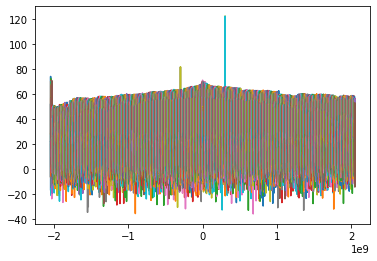

In [22]:
plot_opfb_bins(opfb_shifted,all_bins);
#plt.xlim([1.0e9,1.1e9])

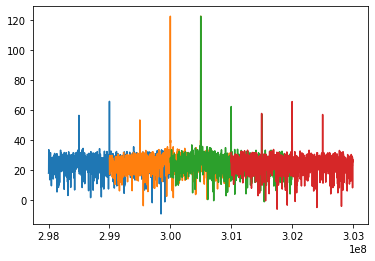

In [25]:
plot_opfb_bins(opfb_shifted,[2347,2348,2349,2350]);